In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy import stats
import math

raw_data = pd.read_csv('data.csv',encoding='unicode_escape')
df = raw_data.copy()


## We want to index the missing IDs so that we can replace those missing values
We want to index the missing values by the invoice date as this indicates that they're the same person

In [2]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values(by=['InvoiceDate'])

existing_ids=[]
existing_ids = set(df['CustomerID'].dropna())

# Identify the specific range of customer IDs
min_customer_id = 12346

# Group by 'InvoiceDate' and count null values in 'CustomerID' column
List_missing_IDs = df.groupby('InvoiceDate')['CustomerID'].apply(lambda x: x.isnull().sum())

missing_ids = []
new_ID = min_customer_id

## We iterate over the groupby to get the missing values

We want the for loop to create new IDs for us

In [3]:
# Iterate through the index and value of the Series using 'items' method
for date, missing_count in List_missing_IDs.items():
    if new_ID in existing_ids:
        new_ID +=1
    else:
        missing_ids.append(new_ID)
        new_ID +=1

for date, count in List_missing_IDs.items():
    if count > 0:
        mask = (df['InvoiceDate'] == date) & (df['CustomerID'].isnull())
        df.loc[mask, 'CustomerID'] = missing_ids.pop(0)

## There are negative values for the quantity and unit price

### This might indicate discounts and return purchases of some form thus we filter them out for our RFM valuation

In [4]:
df = df[(df['Quantity']>0)]
df = df[(df['UnitPrice']>0)]

df.describe(include='all')

C:\Users\27722\AppData\Local\Temp\ipykernel_14144\3160841125.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,530104,530104,530104,530104.000000,530104,530104.000000,530104.000000,530104
unique,19960,3922,4026,NaN,18499,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114,2265,2323,NaN,1114,NaN,NaN,485123
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,10.542037,NaN,3.907625,15754.831646,NaN
std,NaN,NaN,NaN,155.524124,NaN,35.915681,2096.671012,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.001000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,14049.000000,NaN


# We want to build a RFM profile for our customer dataset

## We first start with the Recency profile

In [5]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])
# keep only the most recent date of purchase
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min').astype(int)
df_rec = df[df['rank']==1]
# We now want to assign a recency score(in days) for each customer based on their last purchase
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

C:\Users\27722\AppData\Local\Temp\ipykernel_14144\3005524351.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


In [6]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236270 entries, 0 to 541776
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    236270 non-null  object        
 1   StockCode    236270 non-null  object        
 2   Description  236270 non-null  object        
 3   Quantity     236270 non-null  int64         
 4   InvoiceDate  236270 non-null  datetime64[ns]
 5   UnitPrice    236270 non-null  float64       
 6   CustomerID   236270 non-null  float64       
 7   Country      236270 non-null  object        
 8   Date         236270 non-null  datetime64[ns]
 9   rank         236270 non-null  int32         
 10  recency      236270 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(2), object(4)
memory usage: 20.7+ MB


## We now want to calculate the frequency profile

In [7]:
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

# We now want to combine this data onto our recency profile dataframe
rec_freq = df_freq.merge(df_rec,on='CustomerID')

rec_freq.head()

,CustomerID,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency
0,12346.0,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,2011-01-18 10:01:00,1,48
1,12347.0,31,537626,22212,FOUR HOOK WHITE LOVEBIRDS,6,2010-12-07 14:57:00,2.10,Iceland,2010-12-07 14:57:00,1,6
2,12347.0,31,537626,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET,6,2010-12-07 14:57:00,3.75,Iceland,2010-12-07 14:57:00,1,6
3,12347.0,31,537626,85167B,BLACK GRAND BAROQUE PHOTO FRAME,30,2010-12-07 14:57:00,1.25,Iceland,2010-12-07 14:57:00,1,6
4,12347.0,31,537626,21171,BATHROOM METAL SIGN,12,2010-12-07 14:57:00,1.45,Iceland,2010-12-07 14:57:00,1,6


## Now the Monetary Value profile

In [8]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

rfm = m.merge(rec_freq,on='CustomerID')
# The dataframe we want to work on is the rfm values thus we shall create a df with these values to do our customer segmentation

finaldf = rfm[['CustomerID','recency','frequency','monetary_value']]

# Preprocessing the data for our algorithm
### Removing outliers and feature scaling

recency: 


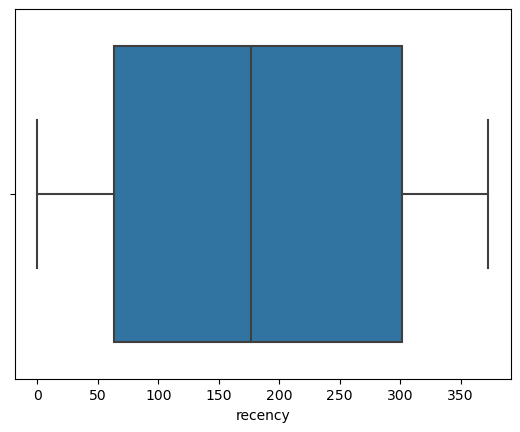

frequency: 


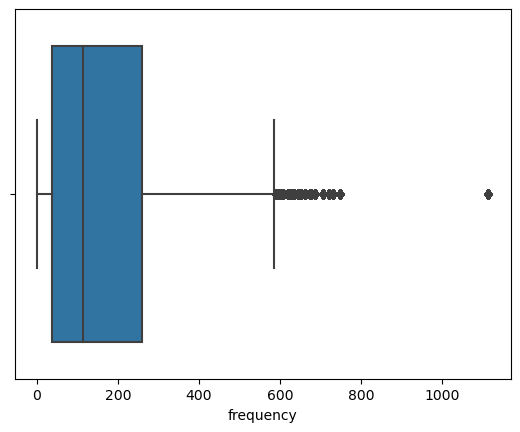

monetary_value: 


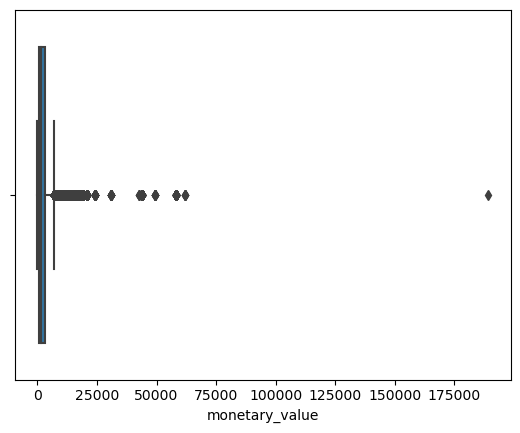

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

# We explore the data to see if there are any outliers

In [10]:
from scipy import stats

# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

### Standardization

In [11]:
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

# Building The Customer Segmentation Model

## To find the best model to build we need to first test to see which clustering method to deploy

### We shall use the elbow method to find the optimal number of clusters

c:\Users\27722\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


Text(0, 0.5, 'Inertia')

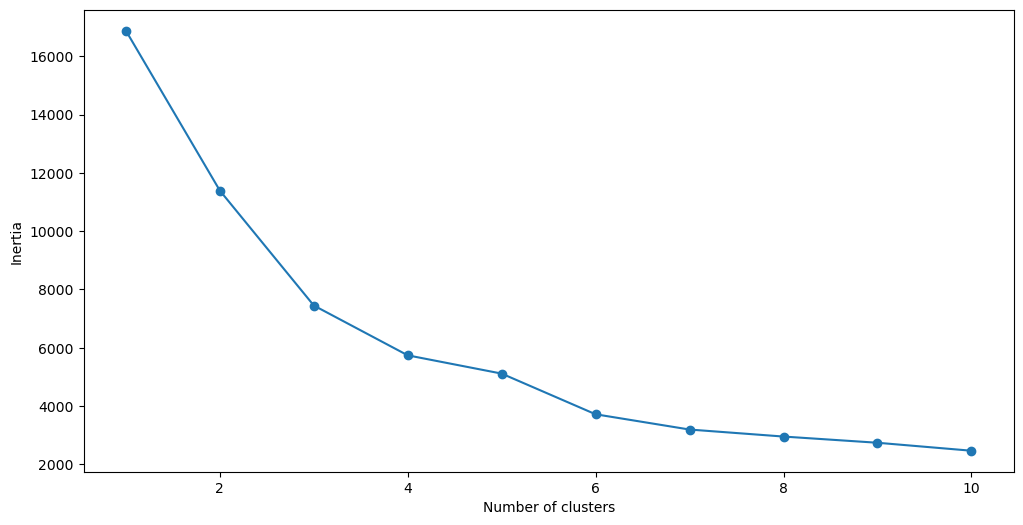

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
SSE = []
for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++', n_init='auto', max_iter=1000, random_state=0,algorithm='elkan')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,11), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Text(0, 0.5, 'Silhouette scores')

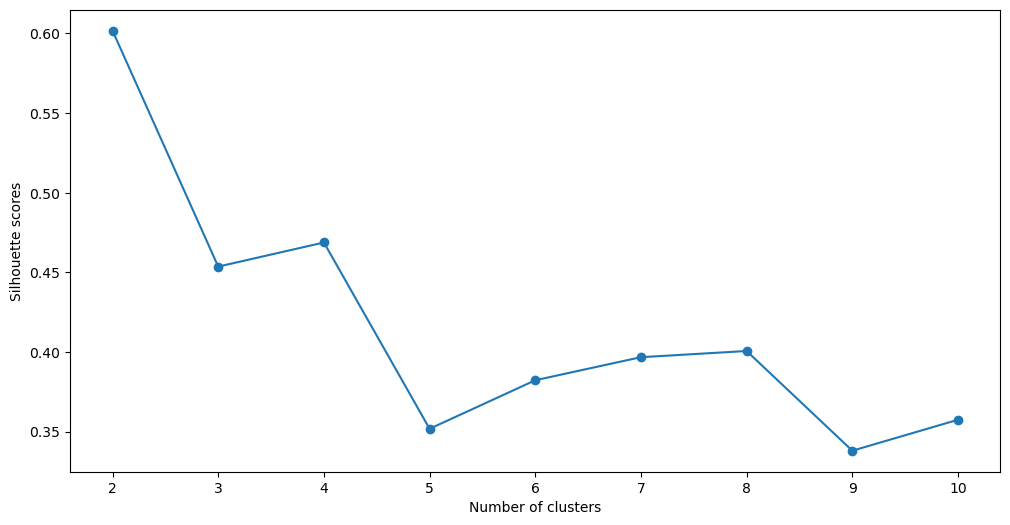

In [13]:
Sil_scores = []
for cluster in range(2,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++', n_init='auto', max_iter=1000, random_state=0,algorithm='elkan')
    kmeans.fit(scaled_features)
    Sil_scores.append(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

plt.figure(figsize=(12,6))
plt.plot(range(2,11), Sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette scores')

## The optimal cluster number is found to be 4 thus we shall build according to this

In [14]:
# First, build a model with 4 clusters
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init='auto', max_iter=1000, random_state=0,algorithm='elkan')
kmeans.fit(scaled_features)

# We want to tr=est the performance of our data
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.4687695401155876


### Now we interprete the results and visualize

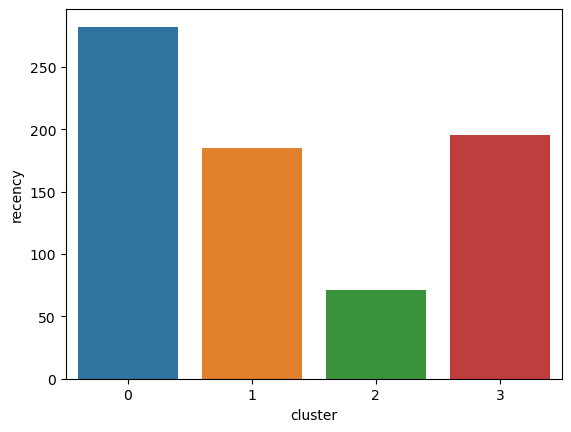

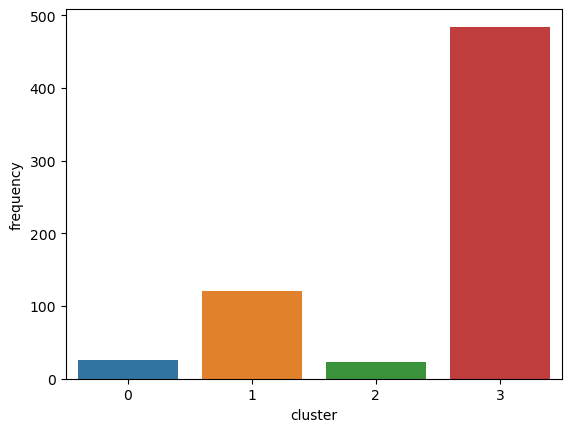

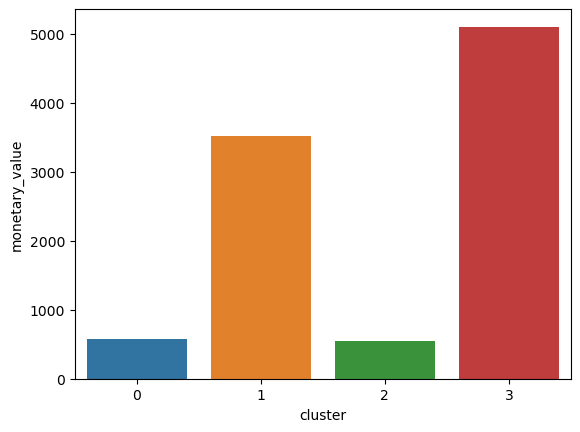

In [15]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()

We want to fit to the original dataframe, we need to scale the values first to fit the model then inverse the scaling

In [16]:
#scale
scaled_units = scaler.transform(rfm[['recency','frequency','monetary_value']].values)

rfm['Cluster'] = kmeans.predict(scaled_units)
rfm.info()

c:\Users\27722\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 236270 entries, 0 to 236269
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   CustomerID      236270 non-null  float64       
 1   monetary_value  236270 non-null  float64       
 2   frequency       236270 non-null  int64         
 3   InvoiceNo       236270 non-null  object        
 4   StockCode       236270 non-null  object        
 5   Description     236270 non-null  object        
 6   Quantity        236270 non-null  int64         
 7   InvoiceDate     236270 non-null  datetime64[ns]
 8   UnitPrice       236270 non-null  float64       
 9   Country         236270 non-null  object        
 10  Date            236270 non-null  datetime64[ns]
 11  rank            236270 non-null  int32         
 12  recency         236270 non-null  int64         
 13  total           230556 non-null  float64       
 14  Cluster         236270 non-null  int

In [17]:
rfm.to_csv('RFMdata.csv')

In [18]:
#I want to count the number of customers in each cluster
rfm.groupby("Cluster").agg({"CustomerID":"count","Quantity":"sum","UnitPrice":"mean","total":"sum"})

,CustomerID,Quantity,UnitPrice,total
Cluster,,,,
0,50409,355278,4.634335,1113925.991
1,66475,436214,5.211369,2226272.150
2,70753,508339,4.480356,1636069.360
3,48633,253360,5.224772,1024441.240


In [19]:
rfm.pivot_table(index='Cluster').drop(columns=['CustomerID','rank'])

C:\Users\27722\AppData\Local\Temp\ipykernel_14144\2127818724.py:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  rfm.pivot_table(index='Cluster').drop(columns=['CustomerID','rank'])


,Quantity,UnitPrice,frequency,monetary_value,recency,total
Cluster,,,,,,
0,7.047908,4.634335,58.985082,809.848525,283.447440,22.669801
1,6.562076,5.211369,184.656863,2850.084360,200.639158,34.320037
2,7.184699,4.480356,53.254124,759.187970,73.131825,23.674095
3,5.209631,5.224772,525.490613,6253.907850,206.931795,21.593096


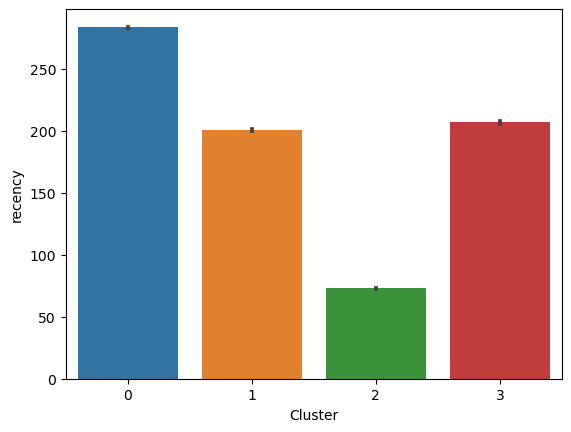

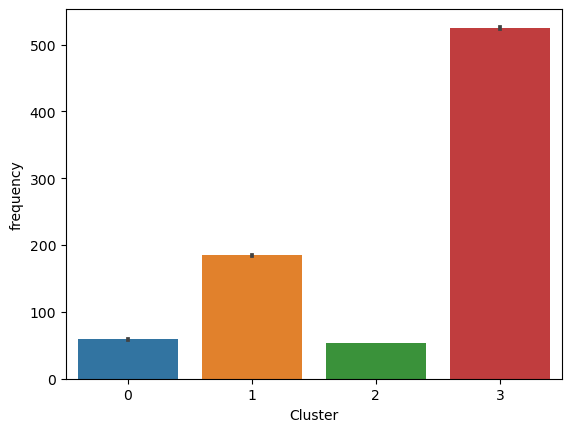

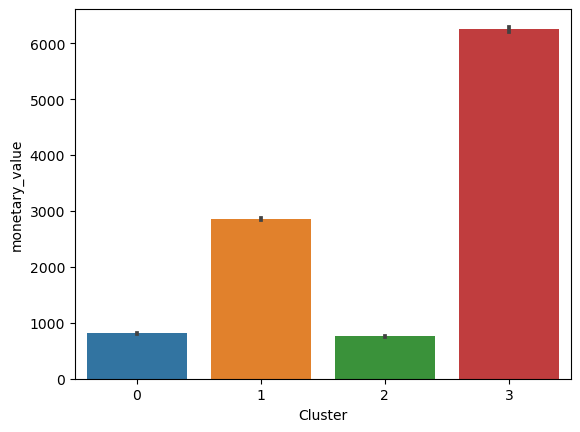

In [20]:
for i in list1:
    sns.barplot(x='Cluster',y=str(i),data=rfm)
    plt.show()